# Programming Assignment 2: Naïve Bayes
## Part 2: Classification

#### Name: Muhammad Waleed
#### Roll Number: 22030017

### Instructions
*   In this part of the assignment you will be implementing a Naïve Bayes Classification Model for classification from scratch.
*   Your code must be in the Python programming language.
*   You are encouraged to use procedural programming and throughly comment your code.
*   For Part 2, you can only use standard libraries i.e. numpy, pandas, regex, matplotlib and scipy. You are **not** allowed to use any machine learning toolkits or libraries for training and testing your model. 
*   **Carefully read the submission guidelines, plagiarism and late days policy.**

### Submission Guidelines
Submit your code both as notebook file (.ipynb) and python script (.py) as individual files on LMS. Name both files as RollNumber_PA2_PartNum, i.e. this part should be named as `2xxxxxxx_PA4_2`. If you don’t know how to save .ipynb as .py see [this](https://i.stack.imgur.com/L1rQH.png). Failing to submit any one of them might result in the reduction of marks. All cells **MUST** be run to get credit.

### Plagiarism Policy
The code **MUST** be done independently. Any plagiarism or cheating of work from others or the internet will be immediately referred to the DC. If you are confused about what constitutes plagiarism, it is **YOUR** responsibility to consult with the instructor or the TA in a timely manner. No “after the fact” negotiations will be possible. The only way to guarantee that you do not lose marks is **DO NOT LOOK AT ANYONE ELSE'S CODE NOR DISCUSS IT WITH THEM**.

### Late Days Policy

The deadline for the assignment is final. However, in order to accommodate all the 11th-hour issues, there is a late submission policy i.e. you can submit your assignment within 3 days after the deadline with a 25% deduction each day.


### Introduction

In this part, you will be implementing and training a Naïve Bayes Classification model to classify news articles into different categories. Specifically, you will need to implement [this](https://drive.google.com/file/d/1lNXwNpU6ydeP8I6cPsXLdbA4RQu17G9E/view?usp=sharing) algorithm. For more details of the algorithm and insights into the Naïve Bayes, you can also consult [Chapter 4](https://web.stanford.edu/~jurafsky/slp3/4.pdf) of the Speech and Language Processing book as reference.


### Dataset
You will be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) for the purposes of this part of the assignment. This contains 120,000 training samples and 7600 testing samples of news articles belonging to 4 categories: World, Sports, Business, and Sci/Tech. 
The data has already been spilt into train and test files.
You're required to implement a model that classifies the articles among the 4 aforementioned categories.

Start by importing all required libraries here.

In [344]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 - Loading and Preprocessing the Dataset

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset - both training and test samples

In [345]:
# code here
# Reading the dataset
DataP2 = "/content/drive/MyDrive/Assignment 4/Assignment 4/DataP2/"

train = pd.read_csv(DataP2 + "train.csv")
test = pd.read_csv(DataP2 + "test.csv")

train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Use regex to pre-process the data loaded. Go through the data and use your own discretion to decide on what kind of pre-processing might be required.

In [346]:
# code here

print(f"Total Classes:", len(train["Class Index"].unique()))
# reading stop words
with open(DataP2 + "stop_words.txt", "r") as f:
  stop_words = f.readlines()
  stop_words_list = []
  for i in stop_words:
    i = i.replace("\n", "")
    i = re.sub(r'[^\w\s]', '', i)
    stop_words_list.append(i)
# preprocessing
def pre_process(df):
    l = []
    for i in df:
        s = re.sub(r"http\S+|'s|\n|#\S+|@\S+|[0-9]|[^\w\s]|_", " ", i) # removing links, line breaks, removing tags, punctutations, numbers, single alphabets
        s = re.sub(r"\b[a-zA-Z]\b", "", s)
        s = s.lower()
        para = s.split(" ")
        para_copy = para.copy()
        for j in para_copy:
            if j in stop_words_list or len(j) <= 2:  # removing the stops words
                para.remove(j)

        para = " ".join(para)
        if len(para) != 0:
            para = para.lstrip()
            para = para.replace("  ", " ")
            l.append(para)
    
    return l

Total Classes: 4


In [347]:
# Calling the pre-processing on traing and testing dataset

test["Test"] = test["Title"] + " " + test["Description"]
train["Test"] = train["Title"] + " " + train["Description"]

processed_train = pre_process(train["Test"])
processed_test = pre_process(test["Test"])

In [348]:
# merging the processed data to dataframe
train["processed_Test"] = processed_train
test["processed_Test"] = processed_test

Show the results of your preprocessing by printing a random sample of 10 articles before and after pre-processing.

In [349]:
# code here
for i in range(0, 10):
  print("Before:", train["Test"][i])
  print("After:", train["processed_Test"][i])
  print("")

Before: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
After: wall bears claw back black reuters reuters short sellers wall street dwindling band ultra cynics seeing green

Before: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
After: carlyle looks toward commercial aerospace reuters reuters private investment firm carlyle group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market

Before: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer 

### 2.2 - Training Naïve Bayes

Create a bag of words representation for the data. Also report the number of unique words in your vocabulary, as well as in each class.

In [350]:
# code here
# making vocabulary by getting unique words in training dataset
def make_vocabulary(df, unqiue=True):
    l = []
    for each_article in df:
        words = each_article.split(" ")
        for each_word in words:
            l.append(each_word)
    l = np.array(l)
    if unqiue == True:
      l = np.unique(l)
    return l

vocab = make_vocabulary(train["processed_Test"])
print("Vocab:", len(vocab))

Vocab: 61059


In [351]:
# Creating bag of words for train and test

def make_bag_of_words(vocab, df):
    df = make_vocabulary(df, False)
    temp = [1] * len(vocab)
    dic = np.unique(df, return_counts=True)
    words = dic[0]
    freq = dic[1]
    for i in range(0, len(words)):
      if words[i] in vocab:
        ind = np.where(vocab == words[i])[0]
        if len(ind) >= 1 :
          ind = ind[0]
          temp[ind] = temp[ind] + freq[i]
    return temp


# Separating by class for training and testing
processed_train_1 = train[train.iloc[:, 0] == 1]["processed_Test"]
processed_train_2 = train[train.iloc[:, 0] == 2]["processed_Test"]
processed_train_3 = train[train.iloc[:, 0] == 3]["processed_Test"]
processed_train_4 = train[train.iloc[:, 0] == 4]["processed_Test"]

processed_test_1 = test[test.iloc[:, 0] == 1]["processed_Test"]
processed_test_2 = test[test.iloc[:, 0] == 2]["processed_Test"]
processed_test_3 = test[test.iloc[:, 0] == 3]["processed_Test"]
processed_test_4 = test[test.iloc[:, 0] == 4]["processed_Test"]

# Bag of words for each Separate class
bag_of_words_train_1 = make_bag_of_words(vocab, processed_train_1)
bag_of_words_train_2 = make_bag_of_words(vocab, processed_train_2)
bag_of_words_train_3 = make_bag_of_words(vocab, processed_train_3)
bag_of_words_train_4 = make_bag_of_words(vocab, processed_train_4)

In [352]:
# Getting the acutal ouput of test dataset for evaluation

processed_test_1_actual_labels = test[test.iloc[:, 0] == 1]["Class Index"]
processed_test_2_actual_labels = test[test.iloc[:, 0] == 2]["Class Index"]
processed_test_3_actual_labels = test[test.iloc[:, 0] == 3]["Class Index"]
processed_test_4_actual_labels = test[test.iloc[:, 0] == 4]["Class Index"]

y_test = processed_test_1_actual_labels.tolist() + processed_test_2_actual_labels.tolist() + processed_test_3_actual_labels.tolist() + processed_test_4_actual_labels.tolist()
print("Total test instances:", len(y_test))

Total test instances: 7600


Implement a general `trainNaiveBayes` function that returns log priors and liklehoods for each class in a given dataset. Apply Laplace smoothing.

In [353]:
# code here
# Training
def trainNaiveBayes(train, vocab, bag_of_words, c):
  logprior = []
  loglikelyhood = []
  for i in range(0, len(c)):
    N_doc = len(train["Title"])
    track = i
    N_c = len(train[train["Class Index"] == i+1])
    logprior_class = N_c/N_doc
    logg = np.log(track+1)
    logprior.append(logprior_class)
    bag = np.array(bag_of_words[i])
    all_words_sum = sum(bag)
    loglikelyhood_class = bag/all_words_sum
    loglikelyhood.append(loglikelyhood_class)
  return logprior, loglikelyhood


Call the function on the training data to train your model.

In [354]:
# code here
bag_of_words = [bag_of_words_train_1, bag_of_words_train_2, bag_of_words_train_3, bag_of_words_train_4] # Each nested list contains bag of words per article having same class
c = [processed_train_1, processed_train_2, processed_train_3, processed_train_4] # Each nested list contains articles having same class

logprior, loglikelihood = trainNaiveBayes(train, vocab, bag_of_words,c)

### 2.3 - Testing Naïve Bayes

Create a `testNaiveBayes` function that return predicted class for each article.

In [355]:
# code here

# Method for testing
def testNaiveBayes(testdoc, logprior, loglikelihood, c, vocab):
  result = []
  for i in range(0, len(testdoc)):
    result2 = []
    for j in c[i]:
      splits = j.split(" ")
      for k in splits:
        if k not in vocab:
          splits.remove(k)
      all_likely = []
      for i in range(0, len(testdoc)):
        likely = logprior[i]
        for s in splits:
          try:
            ind = np.where(vocab == s)[0][0]
            likely = likely*loglikelihood[i][ind]
          except:
            pass
        all_likely.append(likely)
      result2.append(all_likely.index(max(all_likely))+1) 
    result.append(result2)

  return result

Create an `evaluation` function that returns the accuracy, f1 score, and confusion matrix for test predictions

In [362]:
# code here


# this eval method is to create a confusion matrix
def evaluation (predict, actual, show_matrix = False, show_heat_map = False, distance="Euclidean"):

  # Confusion matrix.
  data = {'0': [0, 0, 0, 0], '1': [0, 0, 0, 0],
          '2': [0, 0, 0, 0], '3': [0, 0, 0, 0]}

  data2 = {"Index Class": [1,2,3,4], "Accuracy": [0, 0, 0, 0], 'Precision': [0, 0, 0, 0],
          'Recall': [0, 0, 0, 0], 'F1_score': [0, 0, 0, 0]}


  df = pd.DataFrame(data)  

  # Metrics for each classification.

  TP = [0, 0, 0, 0]
  TN = [0, 0, 0, 0]
  FN = [0, 0, 0, 0]
  FP = [0, 0, 0, 0]

  Accuracy  = [0, 0, 0, 0]
  Precision  = [0, 0, 0, 0]
  Recall = [0, 0, 0, 0]
  F1_score = [0, 0, 0, 0]

  count = [1, 2, 3, 4]

  # Calculating metrics for given dataset

  for i in range(0, len(actual)):
    if int(predict[i]) == int(actual[i]):
      value = df.loc[int(predict[i]), [str(int(predict[i]))]][0] + 1

      df.loc[int(predict[i]), [str(int(predict[i]))]] = value + 1

    else:
      value = df.loc[int(actual[i]), [str(int(predict[i]))]][0] + 1
      df.loc[int(actual[i]), [str(int(predict[i]))]] = value + 1

  
  for i in range(0, 4):
    FP[i] = df.iloc[:,i].sum() - df.loc[i, [str(i)]][0]
    TP[i] = df.loc[i, [str(i)]][0]
    FN[i] = df.iloc[i,:].sum() - df.loc[i, [str(i)]][0]


    df2 = df.copy()
    df2 = df2.drop(i, axis=0)
    df2 = df2.drop(str(i), axis=1)
    TN[i] = df2.values.sum()
    df2 = df.copy()

    Accuracy[i] = (TP[i] + TN[i])/(TP[i]+TN[i]+FP[i]+FN[i])
    Precision[i] = TP[i]/(TP[i]+FP[i])
    Recall[i] = TP[i]/(TP[i]+FN[i])
    F1_score = (2*TP[i])/(2*TP[i]+FP[i]+FN[i])

  data2["Accuracy"] = Accuracy
  data2["Precision"] = Precision
  data2["Recall"] = Recall
  data2["F1_score"] = F1_score

  metrics = pd.DataFrame(data2)
  df.rename(columns = {'0':'1', '1':'2', '2':'3', '3':'4'}, inplace = True)
  df.index = ['1', '2', '3', '4']
  if show_matrix == True:
    print(metrics)
    print()

  if show_heat_map == True:
    s = sns.heatmap(df, annot=True, fmt='d')
    s.set(xlabel='Gold Labels', ylabel='Predicted Labels')
    s.set_title('Heat Map ' + distance)
    plt.show()

  return Accuracy, Precision, Recall, F1_score


Use the defined functions to predict labels for the test data and evaluate your model's performance. Print the output.

In [357]:
# code here
testdoc = [bag_of_words_test_1, bag_of_words_test_2, bag_of_words_test_3, bag_of_words_test_4]
c = [processed_test_1, processed_test_2, processed_test_3, processed_test_4]
y_pred = testNaiveBayes(testdoc, logprior, loglikelihood, c, vocab)

   Index Class  Accuracy  Precision    Recall  F1_score
0            1  0.951711   0.912763  0.892105  0.879144
1            2  0.981842   0.951332  0.977368  0.879144
2            3  0.930526   0.868817  0.850526  0.879144
3            4  0.939079   0.872087  0.886316  0.879144



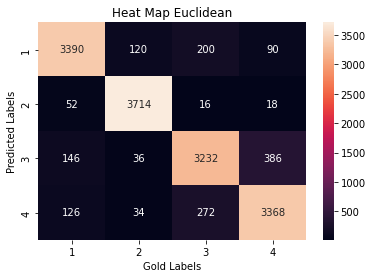

In [364]:
result = []
for i in y_pred:
  result = result + i
result = np.array(result)
y_test = np.array(y_test)

Accuracy, Precision, Recall, F1_score = evaluation (result-1, actual=y_test-1, show_matrix=True, show_heat_map=True)

### 2.4 - Discussion

Answer the following questions:
- How did you decide what kind of pre-processing to do? How did this effect the performance of the classifier?
- How does your f1 score rate the performance of your model? What can be done to improve it?
- The given dataset has an equal number of samples in each class. How, if at all, would the performance of the model change if the data had a class imbalance?
- The fundamental Naïve Bayes assumption is that each feature makes an independent and equal contribution to the outcome. Is this strictly true for this dataset? How might the assumption have impacted the predictions?

###Ques 1. How did you decide what kind of pre-processing to do? How did this effect the performance of the classifier?

Ans: I removed the following things:

1) Stop words: as they are common and not useful to determine the class.

2) Single characters: as they are common too and makes no sense for class.

3) Double characters: very few and are not articles specific.

4) Punctuations: as they can give a negative impact.

5) Tags: They are few and diverse so it is not worth it.

6) Numbers: Same, as numbers are not useful.

7) Line breaks: Removed \n.

8) Removed links (If present): Links are quite diverse so they are not useful for training.

###Ques 2. How does your f1 score rate the performance of your model? What can be done to improve it?

Ans: f1 score showing that model is performing quite well.

###Ques 3. The given dataset has an equal number of samples in each class. How, if at all, would the performance of the model change if the data had a class imbalance?

Ans: The posterior probability will be badly affected by prior if the classes are not balance thus the model will not perform well.

###Ques 4. The fundamental Naïve Bayes assumption is that each feature makes an independent and equal contribution to the outcome. Is this strictly true for this dataset? How might the assumption have impacted the predictions?

Ans: By considering the current scenario, this is not strictly true. In the document their are pair of words that makes sense together which is not consider in Naive Bayes that can affect the predicitions.


